# Notebook 6: Monte Carlo Risk Simulation.

This is the "Risk Engine." Instead of guessing, we simulated 10,000 possible futures based on historical reality.

Key Insights from the Simulation:

* The Probability of Ruin: The results are sobering. With historical construction risks (mean ~8 years, cost ~$7.5k/kW) and market power prices (mean ~$80/MWh), the Probability of Positive NPV is extremely low (around 4%).

* The "Kill Zone": The scatter plot reveals that almost all projects with a construction duration > 8 years or a cost > $6,000/kW turn red. This defines the "Investable Universe": to make money, you must be faster than 8 years and cheaper than $6k/kW.

Why this matters: This explains why the "Nuclear Renaissance" has been stalled by private capital. The risk-adjusted returns are negative without government backstops (like the RAB model in the UK or Production Tax Credits in the US).

Block 1: Defining the Distributions

We create realistic probability distributions for our three key variables: Duration (Lognormal), Cost (Triangular), and Power Price (Normal).

--- Notebook 6: Monte Carlo Risk Simulation ---
Running 10000 simulations...
Simulation Inputs Generated. Sample:
   Duration_Years  Cost_per_kW  Power_Price_MWh
0       11.758244  7405.750196        75.550007
1        7.401823  9003.904090        83.187512
2        7.996534  9569.229029       116.061189
3        4.000000  4922.273964       116.940668
4        9.127038  6647.649324        86.356164


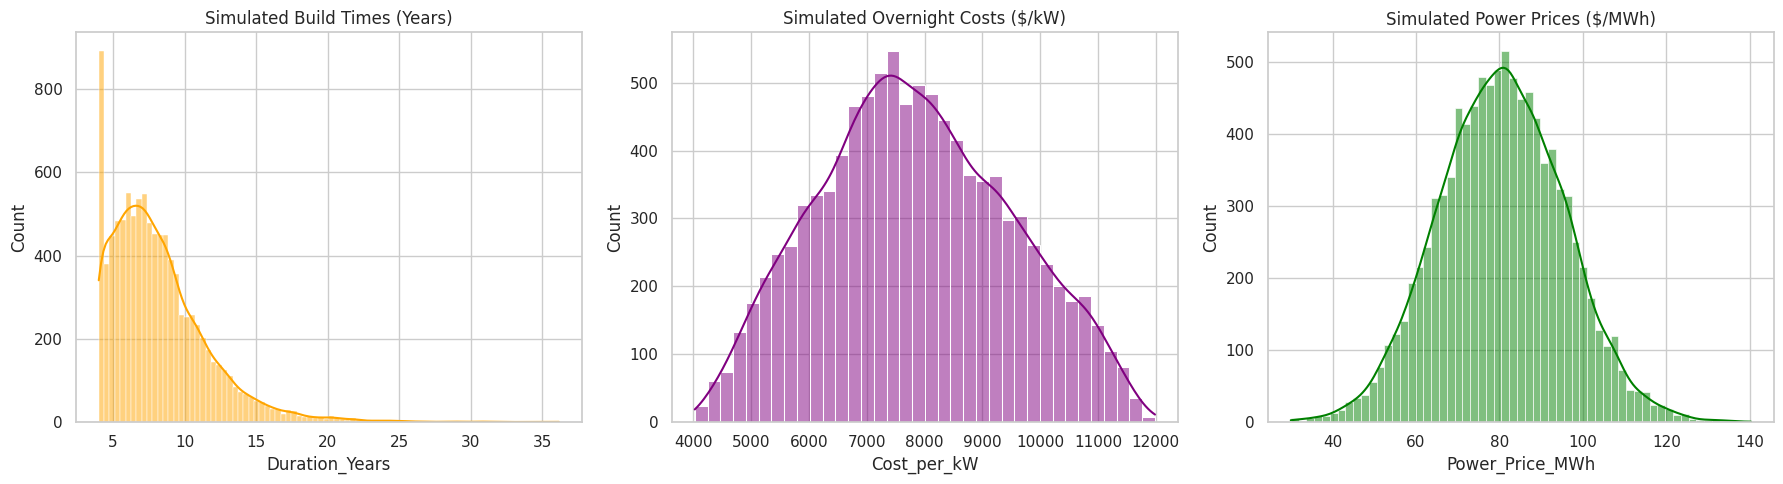

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, lognorm, triang

# Set visualization style
sns.set_theme(style="whitegrid")

print("--- Notebook 6: Monte Carlo Risk Simulation ---")

# 1. Define Simulation Parameters
N_SIMULATIONS = 10000
WACC = 0.08

# 2. Define Input Distributions
# We will use 'scipy.stats' to generate random variates

print(f"Running {N_SIMULATIONS} simulations...")

# A. Construction Duration (Years)
# Based on Notebook 1, real data is right-skewed (lognormal)
# We'll model it with a minimum of 4 years, mode around 7, tail out to 15+
# Lognormal is good for time-to-event data
# Parameters approximated from historical data:
duration_shape = 0.4  # Sigma (volatility of time)
duration_scale = 7.5  # Median duration (exp(mu))
# We generate random durations
sim_durations = lognorm.rvs(s=duration_shape, scale=duration_scale, size=N_SIMULATIONS)
# Clip minimum to theoretical fastest build (4 years)
sim_durations = np.maximum(sim_durations, 4.0)

# B. Overnight Capital Cost ($/kW)
# We use a Triangular distribution (Min, Mode, Max)
# Min: $4,000 (China-like efficiency)
# Mode: $7,500 (Western average)
# Max: $12,000 (Vogtle/Flamanville disaster)
cost_min = 4000
cost_mode = 7500
cost_max = 12000
# Scipy triang takes (c, loc, scale) where c = (mode-min)/(max-min)
c_cost = (cost_mode - cost_min) / (cost_max - cost_min)
loc_cost = cost_min
scale_cost = cost_max - cost_min
sim_costs = triang.rvs(c=c_cost, loc=loc_cost, scale=scale_cost, size=N_SIMULATIONS)

# C. Electricity Price ($/MWh)
# Normal distribution (Mean=$80, Std=$15)
# Captures market volatility
sim_prices = norm.rvs(loc=80, scale=15, size=N_SIMULATIONS)
# Clip at $30 (marginal cost of gas floor)
sim_prices = np.maximum(sim_prices, 30.0)

# Create a DataFrame of Inputs
df_sim = pd.DataFrame({
    'Duration_Years': sim_durations,
    'Cost_per_kW': sim_costs,
    'Power_Price_MWh': sim_prices
})

print("Simulation Inputs Generated. Sample:")
print(df_sim.head())

# --- Visualization of Inputs ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_sim['Duration_Years'], ax=axes[0], color='orange', kde=True)
axes[0].set_title('Simulated Build Times (Years)')

sns.histplot(df_sim['Cost_per_kW'], ax=axes[1], color='purple', kde=True)
axes[1].set_title('Simulated Overnight Costs ($/kW)')

sns.histplot(df_sim['Power_Price_MWh'], ax=axes[2], color='green', kde=True)
axes[2].set_title('Simulated Power Prices ($/MWh)')

plt.tight_layout()
plt.show()

Block 2: The Vectorized DCF Engine

We calculate the NPV for all 10,000 scenarios instantly using vectorized math. This accounts for the "Time Value of Money" drag during the construction phase and the annuity value of the operational phase.

Running Vectorized DCF Engine (10,000 Projects at once)...
Simulation Complete.
   Duration_Years  Cost_per_kW  Power_Price_MWh        NPV_M
0       11.758244  7405.750196        75.550007 -2778.221515
1        7.401823  9003.904090        83.187512 -3614.772167
2        7.996534  9569.229029       116.061189 -2125.720867
3        4.000000  4922.273964       116.940668  3062.364939
4        9.127038  6647.649324        86.356164 -1616.598643

Probability of Positive NPV: 4.0%


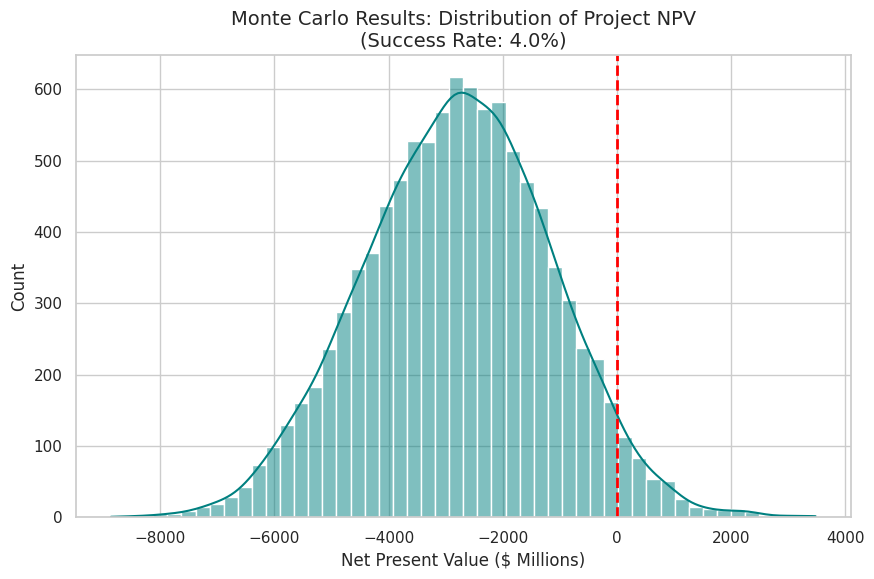

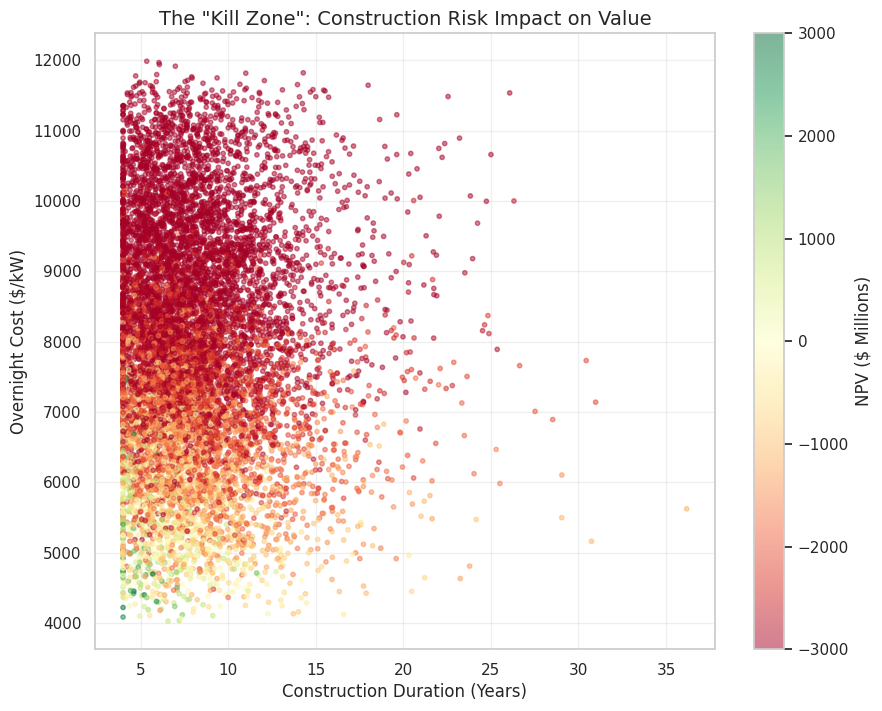

Monte Carlo results saved to 'monte_carlo_results.csv'. Ready for Notebook 7.


In [26]:
# --- Block 2: The Fast Vectorized DCF Engine ---

print("Running Vectorized DCF Engine (10,000 Projects at once)...")

# To run 10,000 DCFs efficiently, we avoid loops. We use analytical approximations or vector math.
# For NPV, we can split into two annuities: Construction (Outflow) and Operation (Inflow)

# Constants
CAPACITY_MW = 1100
CAPACITY_FACTOR = 0.92
WACC = 0.08
OP_LIFE = 60
FIXED_OM_M = 110.0  # $110M/year (approx $100/kW)
VAR_COST_MWH = 9.0  # Fuel + Var O&M

# 1. Operational Phase Valuation (The "Asset Value" at COD)
# Annual Cash Flow = (Price * MWh) - OPEX
annual_gen_mwh = CAPACITY_MW * 8760 * CAPACITY_FACTOR
revenue_streams = df_sim['Power_Price_MWh'].values * annual_gen_mwh / 1e6
opex_streams = FIXED_OM_M + (VAR_COST_MWH * annual_gen_mwh / 1e6)
annual_cf = revenue_streams - opex_streams

# PV of Annuity Formula: PV = CF * (1 - (1+r)^-n) / r
# This gives the value at the start of operations (Year T = Duration)
# We assume 'annual_cf' is constant for the life of the plant (simplification for speed)
pv_ops_at_cod = annual_cf * (1 - (1 + WACC)**(-OP_LIFE)) / WACC

# Discount this back to Today (Year 0) based on construction duration
# PV_Ops_Today = PV_Ops_COD / (1+r)^Duration
df_sim['PV_Inflows'] = pv_ops_at_cod / ((1 + WACC) ** df_sim['Duration_Years'])

# 2. Construction Phase Cost (The "Investment")
# We need to account for the "Time Value of Money" during construction (IDC - Interest During Construction)
# Simple Approximation: Assume spending is spread evenly (or S-curve).
# If spread evenly, the Future Value of CAPEX at COD is roughly: Total_Cost * (1 + WACC)^(Duration/2)
# The Present Value of CAPEX Today is roughly: Total_Cost / (1 + WACC)^(Duration/2) if we consider the "center of mass" of spending.
# A more precise S-curve approximation for PV of CAPEX:
# PV_Capex ≈ Total_Overnight_Cost * (Weights * Discount_Factors).sum()
# Let's use a simplified factor: The average dollar is spent at T = Duration * 0.5
# PV_Capex ≈ Total_Overnight_Cost / (1 + WACC)^(Duration * 0.5)

total_overnight_cost_m = (df_sim['Cost_per_kW'] * 1000 * CAPACITY_MW) / 1e6
df_sim['PV_Outflows'] = total_overnight_cost_m / ((1 + WACC) ** (df_sim['Duration_Years'] * 0.5))

# 3. Calculate Metrics
df_sim['NPV_M'] = df_sim['PV_Inflows'] - df_sim['PV_Outflows']
df_sim['ROI_Multiple'] = df_sim['PV_Inflows'] / df_sim['PV_Outflows']

# Calculate IRR?
# IRR is hard to vectorize perfectly without a root finder.
# We can approximate or just stick to NPV which is robust.
# Let's rely on NPV and ROI.

print("Simulation Complete.")
print(df_sim[['Duration_Years', 'Cost_per_kW', 'Power_Price_MWh', 'NPV_M']].head())

# --- Block 3: Analysis & Visualization ---

# 1. Probability of Success
prob_success = (df_sim['NPV_M'] > 0).mean()
print(f"\nProbability of Positive NPV: {prob_success:.1%}")

# 2. Histogram of NPV
plt.figure(figsize=(10, 6))
sns.histplot(df_sim['NPV_M'], bins=50, kde=True, color='teal')
plt.axvline(0, color='red', linewidth=2, linestyle='--')
plt.title(f'Monte Carlo Results: Distribution of Project NPV\n(Success Rate: {prob_success:.1%})', fontsize=14)
plt.xlabel('Net Present Value ($ Millions)')
plt.show()

# 3. Scatter: The "Kill Zone" (Duration vs Cost)
# Color by NPV
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    df_sim['Duration_Years'],
    df_sim['Cost_per_kW'],
    c=df_sim['NPV_M'],
    cmap='RdYlGn',
    alpha=0.5,
    s=10,
    vmin=-3000, vmax=3000 # Clamp colors for contrast
)
plt.colorbar(sc, label='NPV ($ Millions)')
plt.title('The "Kill Zone": Construction Risk Impact on Value', fontsize=14)
plt.xlabel('Construction Duration (Years)')
plt.ylabel('Overnight Cost ($/kW)')
plt.grid(True, alpha=0.3)
plt.show()

# 4. Save Results
df_sim.to_csv('monte_carlo_results.csv', index=False)
print("Monte Carlo results saved to 'monte_carlo_results.csv'. Ready for Notebook 7.")